In [1]:
# %% import necessary tools
print("import necessary tools")
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt
import math
import torch
import gpytorch
import pandas as pd
import tqdm as notebook_tqdm

import necessary tools
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
#%% import data
from sklearn.model_selection import train_test_split
print("import data")
nTrain = 80
df = pd.read_csv('20230628_Area_transfer.csv')  
df = df.sample(frac=1)
noises = df.loc[:,"Stdev (%)"]
x = df.iloc[:,1:4]
y = df.loc[:,"Percent area Transfer (%)"]
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)
x_train = torch.tensor(np.array(x_train))
y_train = torch.tensor(np.array(y_train))
x_test = torch.tensor(np.array(x_test))
y_test = torch.tensor(np.array(y_test))
#x_train = torch.tensor(np.array(x)[:nTrain,:])
#y_train = torch.tensor(np.array(y)[:nTrain])
#noises_train = torch.tensor(np.array(noises)[:nTrain])

#%% pre process data
from sklearn import preprocessing

# need to scale noises only by dividing by stdev of inputs
#noises_train = noises_train/torch.std(x_train)
#noises_train[np.isnan(noises_train)]=np.average(noises_train[np.isnan(noises_train)==False])

# scale x training data per standard scaler to N(0,1)
scaler = preprocessing.StandardScaler().fit(x_train)
x_train = torch.tensor(scaler.transform(x_train))

# apply log to y training data and then scale to N(0,1)
y_train = torch.log(y_train)
y_scaler = preprocessing.StandardScaler().fit(y_train.reshape(-1,1))
y_train = torch.tensor(y_scaler.transform(y_train.reshape(-1,1))).squeeze()
y_test = torch.tensor(y_scaler.transform(y_test.reshape(-1,1))).squeeze()
print(x_train.size())
print(y_train.size())
print(x_test.size())
print(y_test.size())
#noise_scaler = preprocessing.StandardScaler().fit(noises_train.reshape(-1,1))
#noises_train = noise_scaler.transform(noises_train.reshape(-1,1))
#noises_train[np.isnan(noises_train)]=np.average(noises_train[np.isnan(noises_train)==False])
#print(noises_train)

import data
torch.Size([80, 3])
torch.Size([80])
torch.Size([20, 3])
torch.Size([20])


In [3]:
#%%
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=3))
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=3))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
#likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=noises_train,learn_additional_noise=True)
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(x_train, y_train, likelihood)

In [4]:
# %%
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.5)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter=200

print('Starting GP parameter tuning...')
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(x_train)
    # Calc loss and backprop gradients
    loss = -mll(output, y_train)
    loss.backward()
    if np.mod(i,20)==0:
        print('Iter %d/%d - Loss: %.3f   lengthscale 1: %.3f   lengthscale 2: %.3f   lengthscale 3: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale[0][0].item(),
            model.covar_module.base_kernel.lengthscale[0][1].item(),
            model.covar_module.base_kernel.lengthscale[0][1].item(),
        ))
        #print('Iter %d/%d - Loss: %.3f %' (
        #    i + 1, training_iter, loss.item()
            #model.covar_module.base_kernel.lengthscale,
            #model.covar_module.base_kernel.lengthscale[1],
            #model.covar_module.base_kernel.lengthscale[2]
        #))
        #torch.print("lengthscale: "+str(model.covar_module.base_kernel.lengthscale))
    optimizer.step()

Starting GP parameter tuning...
Iter 1/200 - Loss: 1.254   lengthscale 1: 0.693   lengthscale 2: 0.693   lengthscale 3: 0.693
Iter 21/200 - Loss: 0.923   lengthscale 1: 7.279   lengthscale 2: 2.991   lengthscale 3: 2.991
Iter 41/200 - Loss: 0.915   lengthscale 1: 9.530   lengthscale 2: 2.065   lengthscale 3: 2.065
Iter 61/200 - Loss: 0.913   lengthscale 1: 10.414   lengthscale 2: 2.363   lengthscale 3: 2.363
Iter 81/200 - Loss: 0.913   lengthscale 1: 11.024   lengthscale 2: 2.276   lengthscale 3: 2.276
Iter 101/200 - Loss: 0.912   lengthscale 1: 11.563   lengthscale 2: 2.283   lengthscale 3: 2.283
Iter 121/200 - Loss: 0.912   lengthscale 1: 12.067   lengthscale 2: 2.276   lengthscale 3: 2.276
Iter 141/200 - Loss: 0.912   lengthscale 1: 12.542   lengthscale 2: 2.263   lengthscale 3: 2.263
Iter 161/200 - Loss: 0.912   lengthscale 1: 12.992   lengthscale 2: 2.257   lengthscale 3: 2.257
Iter 181/200 - Loss: 0.912   lengthscale 1: 13.419   lengthscale 2: 2.250   lengthscale 3: 2.250


In [5]:
x_test = torch.tensor(np.array(x)[nTrain:,:])
x_test = torch.tensor(scaler.transform(x_test))
y_test = torch.log(torch.tensor(np.array(y)[nTrain:]))
y_test = torch.tensor(y_scaler.transform(y_test.reshape(-1,1))).squeeze()
#print(y_test)

model.eval()
with torch.no_grad():
    trained_pred_dist = likelihood(model(x_test))
    predictive_mean = trained_pred_dist.mean
    lower, upper = trained_pred_dist.confidence_region()
print(predictive_mean)

# scaling back input/output data
y_test_inverse = y_scaler.inverse_transform(y_test.reshape(-1,1))
x_test_inverse = scaler.inverse_transform(x_test)
predictive_mean_inverse = y_scaler.inverse_transform(predictive_mean.reshape(-1,1))

tensor([-1.9827, -1.9309,  0.5661, -0.6327,  0.6234,  0.4592,  0.3158, -0.1766,
        -0.6327,  0.2464,  0.4703,  0.6238, -0.5222,  0.6710, -1.5343, -1.9827,
         0.6152,  0.6234,  0.6014,  0.6327], dtype=torch.float64)


In [6]:
final_nlpd = gpytorch.metrics.negative_log_predictive_density(trained_pred_dist, y_test)
#corr = np.corrcoef(predictive_mean,y_train)[0,1]
print(f'nTrained model NLPD: {final_nlpd:.2f}')
#print('Mean predictions correlated: '+str(corr))

print(y_test)
print(predictive_mean)
print(lower)
print(upper)

nTrained model NLPD: 1.08
tensor([-3.4528, -0.6772,  0.6490, -0.5349,  0.6414,  0.5819,  0.1216,  0.3688,
        -0.9713,  0.3138,  0.6340,  0.5983, -0.5348,  0.6490, -3.5746, -1.7510,
         0.6207,  0.6072,  0.5960,  0.6135], dtype=torch.float64)
tensor([-1.9827, -1.9309,  0.5661, -0.6327,  0.6234,  0.4592,  0.3158, -0.1766,
        -0.6327,  0.2464,  0.4703,  0.6238, -0.5222,  0.6710, -1.5343, -1.9827,
         0.6152,  0.6234,  0.6014,  0.6327], dtype=torch.float64)
tensor([-3.0388, -2.9494, -0.4095, -1.6943, -0.3582, -0.5281, -0.7105, -1.1727,
        -1.6943, -0.8458, -0.7200, -0.3511, -1.5842, -0.3086, -2.5595, -3.0388,
        -0.3597, -0.3582, -0.3868, -0.3564], dtype=torch.float64)
tensor([-0.9267, -0.9123,  1.5416,  0.4289,  1.6049,  1.4465,  1.3421,  0.8195,
         0.4289,  1.3385,  1.6606,  1.5987,  0.5398,  1.6506, -0.5090, -0.9267,
         1.5900,  1.6049,  1.5897,  1.6218], dtype=torch.float64)


20


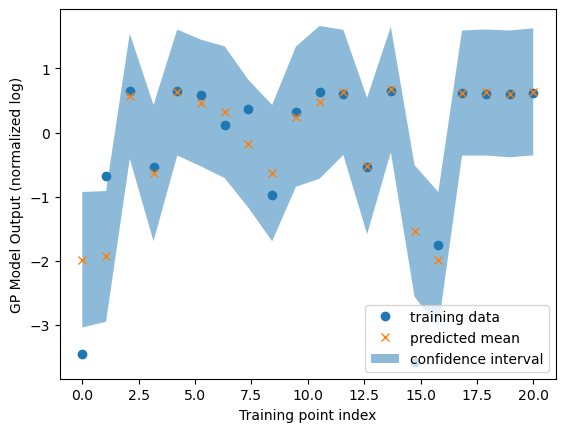

In [7]:
test_size=y_test.size(dim=0)
print(test_size)
testInds = np.linspace(0,int(test_size),num=test_size)
plt.figure()
plt.plot(testInds,y_test,'o',label = 'training data')
plt.plot(testInds,predictive_mean,'x',label='predicted mean')
#plt.plot(testInds,lower,'-',label = 'lower confidence interval')
#plt.plot(testInds,upper,'-',label = 'upper confidence interval')
plt.fill_between(testInds,lower,upper,alpha=0.5, label = 'confidence interval')
plt.xlabel("Training point index")
plt.ylabel("GP Model Output (normalized log)")
plt.legend(loc=4)

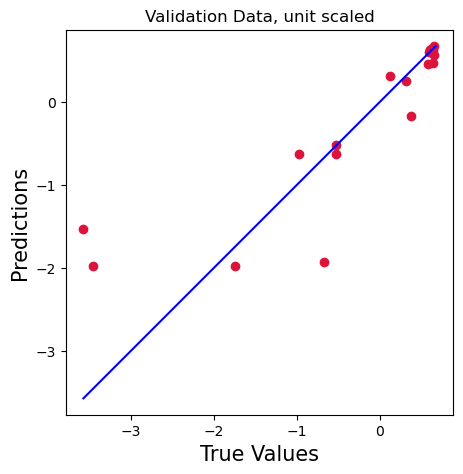

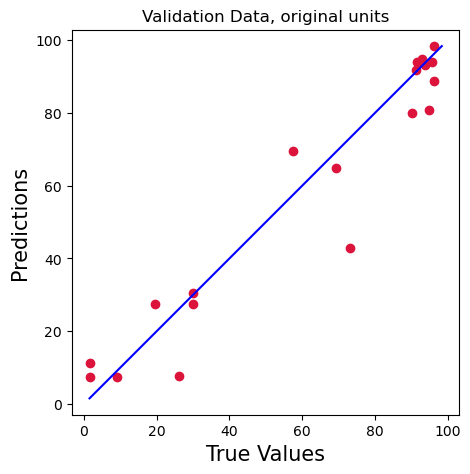

In [8]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, predictive_mean, c='crimson')
#plt.scatter(y_test, lower, c='blue')
#plt.scatter(y_test, upper, c='green')

p1 = max(max(predictive_mean), max(y_test))
p2 = min(min(predictive_mean), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.title("Validation Data, unit scaled")
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(np.exp(y_test_inverse), np.exp(predictive_mean_inverse), c='crimson')
#plt.scatter(y_test, lower, c='blue')
#plt.scatter(y_test, upper, c='green')

p1 = max(max(np.exp(predictive_mean_inverse)), max(np.exp(y_test_inverse)))
p2 = min(min(np.exp(predictive_mean_inverse)), min(np.exp(y_test_inverse)))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.title("Validation Data, original units")
plt.show()

In [9]:
model.mean_module.constant
model.covar_module.base_kernel.lengthscale

tensor([[13.8254,  2.2427,  0.3108]], grad_fn=<SoftplusBackward0>)